In [1]:
import os, yaml, sys
import numpy as np
import torch
import h5py
from torchvision import models
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from scipy.io import loadmat
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import BrainAreas, get_triu_perms, load_img_natraster, get_device, print_wise
from general_utils.dRSA import across_areas_dRSA
device = get_device()

08:40:19 - device being used: mps


In [44]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    monkey_name: str = 'paul' 
    date: str = '230204'
    new_fs: int = 100 # Hz
    RDM_metric: str = 'cosine'
    RSA_metric: str = 'correlation'
cfg = Cfg()

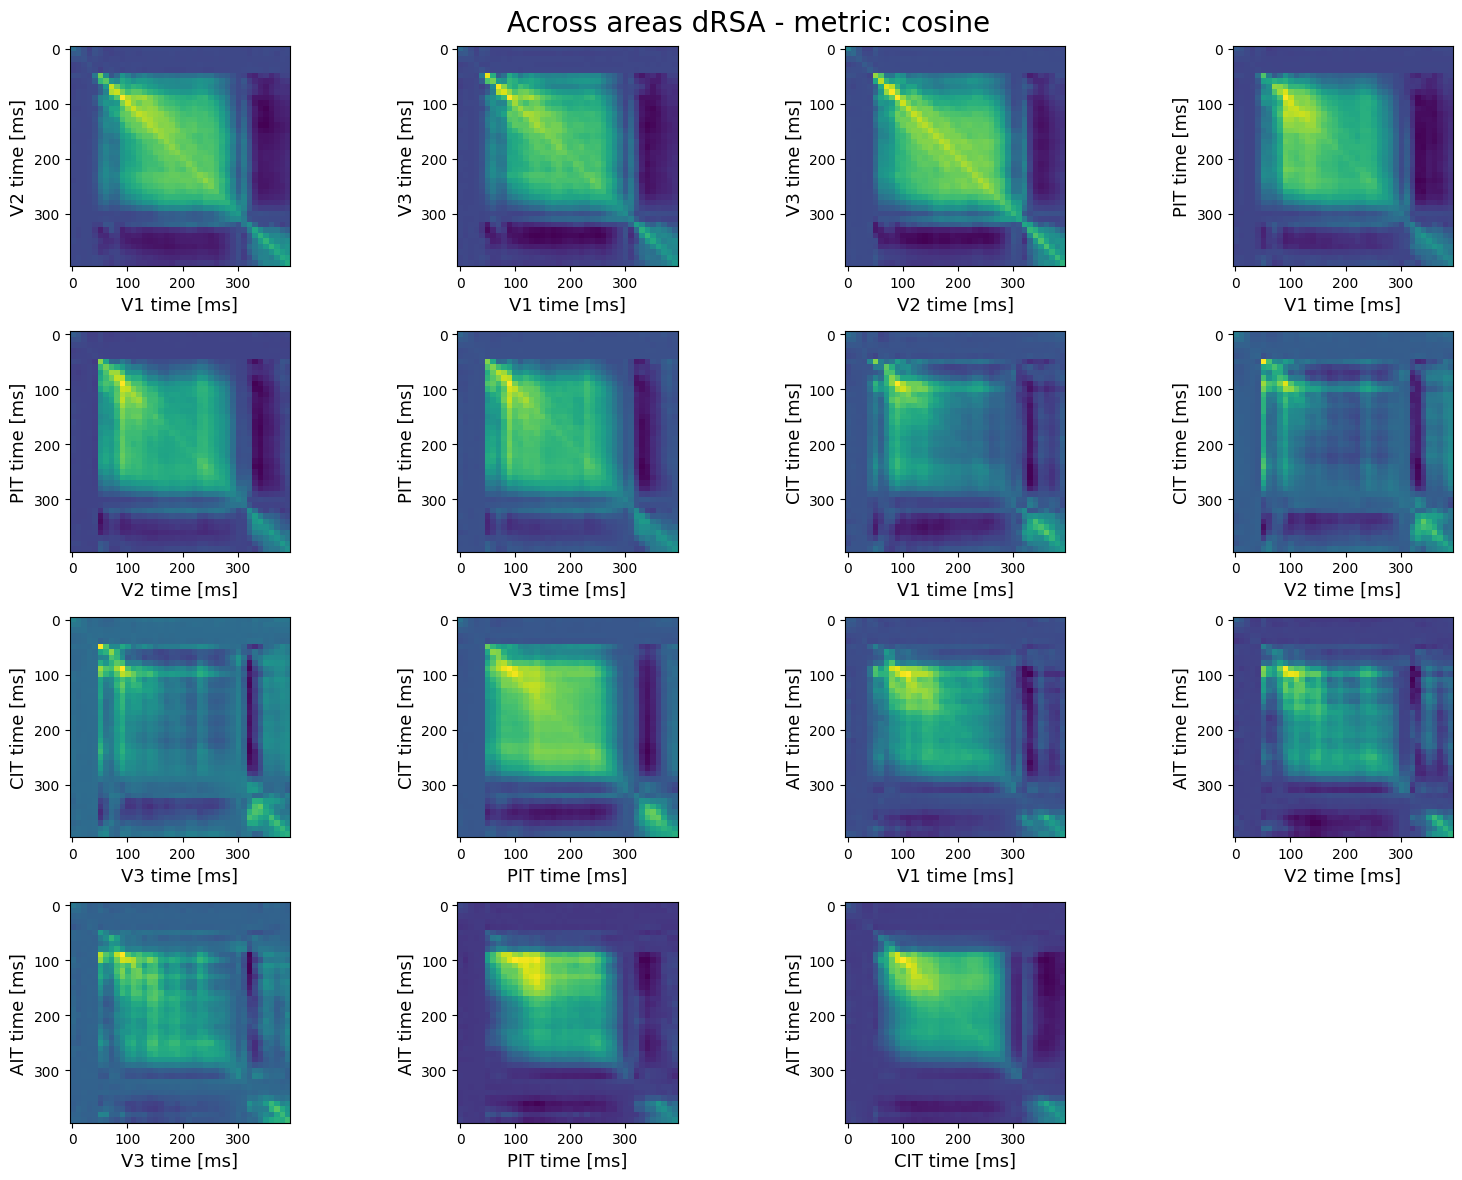

In [45]:
results_folder = f"{paths['livingstone_lab']}/tiziano/results"
ba_obj = BrainAreas(cfg.monkey_name)
brain_areas = ba_obj.get_brain_areas()
tasks_list = get_triu_perms(brain_areas)
n_cols = 4
n_rows = (len(tasks_list) + n_cols - 1) // n_cols  # ceil division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axes = axes.flatten()
for idx, brain_areas_pair in enumerate(tasks_list):
    ax = axes[idx]
    drsa_mat = np.load(f"{results_folder}/{cfg.monkey_name}_{cfg.date}_{brain_areas_pair[0]}-{brain_areas_pair[1]}_images_{cfg.RDM_metric}_{cfg.new_fs}Hz.npz")['data']
    ax.imshow(drsa_mat)
    ax.set_xticks(np.arange(0, drsa_mat.shape[0], 10))
    ax.set_xticklabels(np.round(np.arange(0, drsa_mat.shape[0], 10)*1000/cfg.new_fs).astype(int))
    ax.set_yticks(np.arange(0, drsa_mat.shape[0], 10))
    ax.set_yticklabels(np.round(np.arange(0, drsa_mat.shape[0], 10)*1000/cfg.new_fs).astype(int))
    ax.set_ylabel(f"{brain_areas_pair[0]} time [ms]", fontsize=13)
    ax.set_xlabel(f"{brain_areas_pair[1]} time [ms]", fontsize=13)
    # ax.colorbar(label="Intensity")
fig.suptitle(f"Across areas dRSA - metric: {cfg.RDM_metric}", fontsize=20)
for i in range(len(tasks_list), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

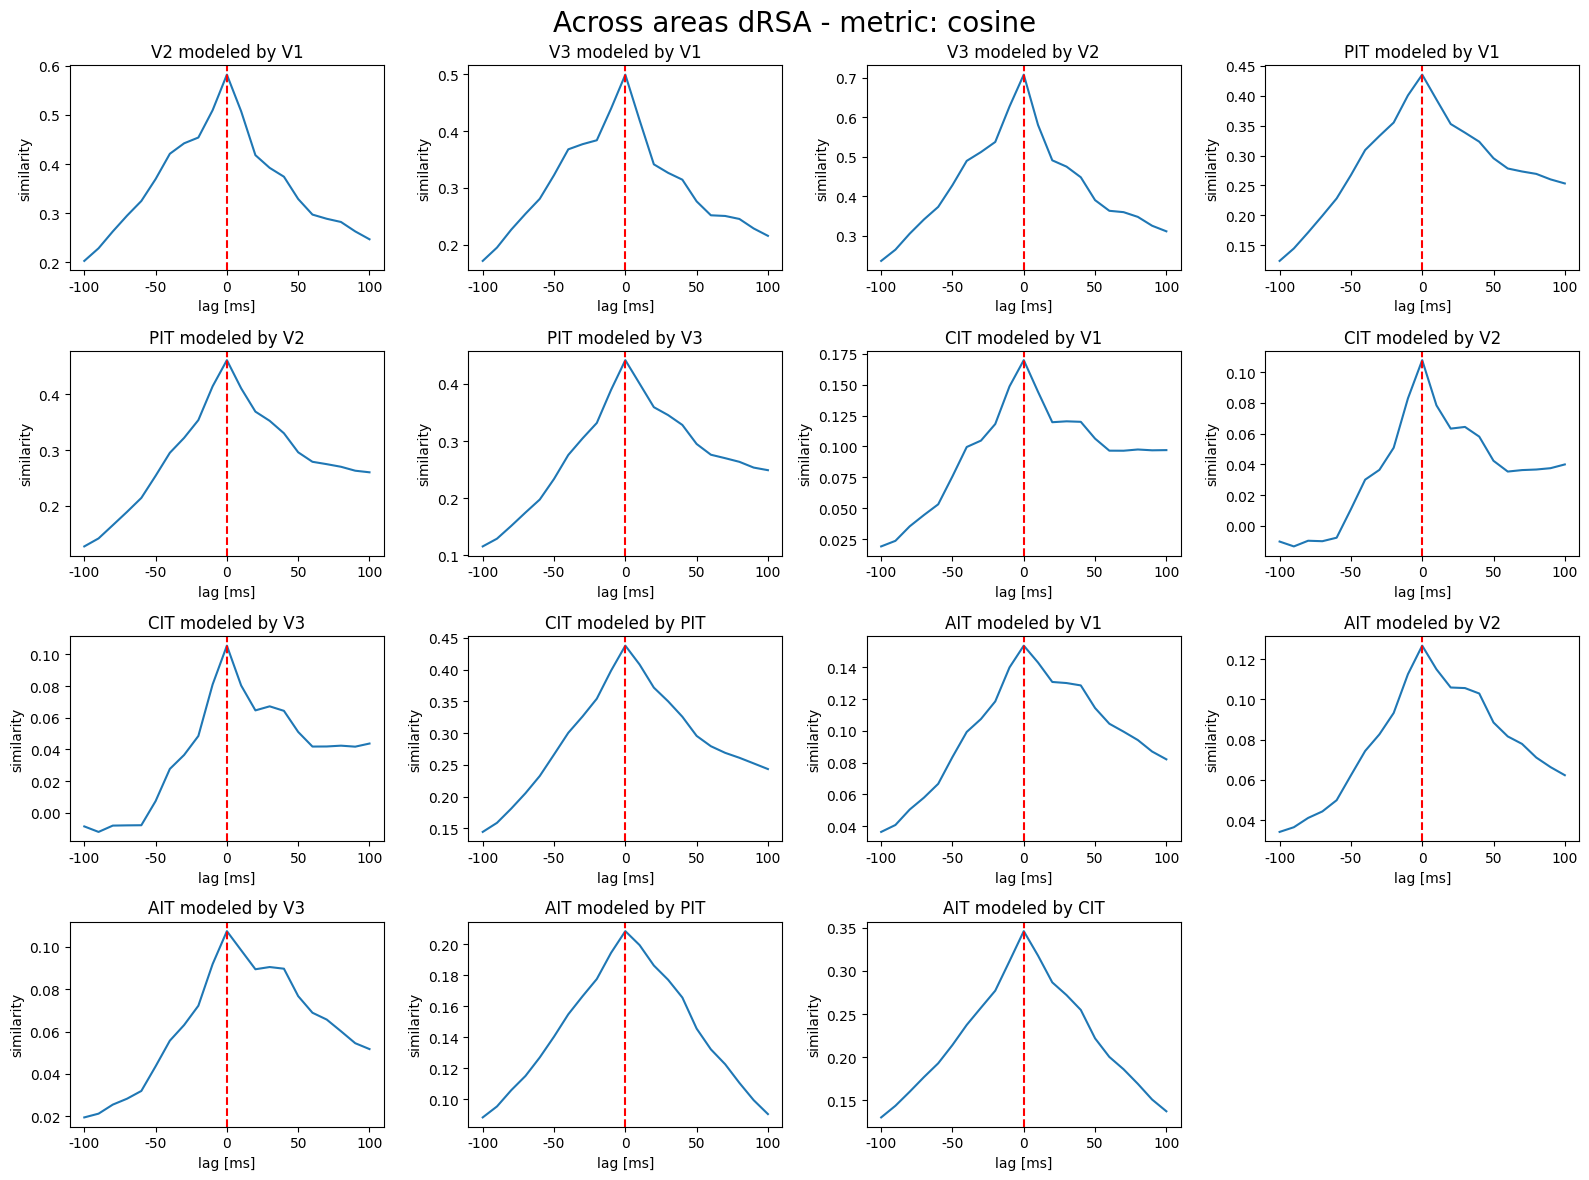

In [46]:
from general_utils.utils import get_lagplot_subset

results_folder = f"{paths['livingstone_lab']}/tiziano/results"
ba_obj = BrainAreas(cfg.monkey_name)
brain_areas = ba_obj.get_brain_areas()
tasks_list = get_triu_perms(brain_areas)
lagplot_lims = (5, 30)
max_lag = 10
x_ticks = np.arange(0, 2*max_lag+1, 5)
x_ticks_labels = np.round(np.arange(-max_lag, max_lag+1, 5)*1000/cfg.new_fs).astype(int)
n_cols = 4
n_rows = (len(tasks_list) + n_cols - 1) // n_cols  # ceil division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axes = axes.flatten()
for idx, brain_areas_pair in enumerate(tasks_list):
    ax = axes[idx]
    drsa_mat = np.load(f"{results_folder}/{cfg.monkey_name}_{cfg.date}_{brain_areas_pair[0]}-{brain_areas_pair[1]}_images_{cfg.RDM_metric}_{cfg.new_fs}Hz.npz")['data']
    ax.plot(get_lagplot_subset(drsa_mat,np.arange(*lagplot_lims), max_lag=max_lag));
    ax.set_title(f"{brain_areas_pair[0]} modeled by {brain_areas_pair[1]}")
    ax.axvline(max_lag, color='r', linestyle='--')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks_labels)
    ax.set_ylabel("similarity")
    ax.set_xlabel("lag [ms]")
for i in range(len(tasks_list), len(axes)):
    fig.delaxes(axes[i])
fig.suptitle(f"Across areas dRSA - metric: {cfg.RDM_metric}", fontsize=20)
plt.tight_layout()
plt.show()

In [140]:
dRSA = compute_dRSA(rasters_smooth[:20, :50, :1000],rasters_smooth[300:330, :50, :1000])

Text(0.5, 1.0, 'V1 -> probe tip')

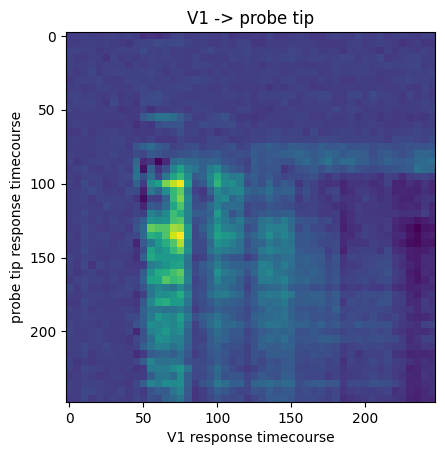

In [241]:
fig, ax = plt.subplots()
ax.imshow(dRSA)
ax.set_xticks([0, 10, 20, 30, 40])
ax.set_xticklabels(np.array([0, 10, 20, 30, 40])*cfg.avg_win)
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_yticklabels(np.array([0, 10, 20, 30, 40])*cfg.avg_win)
ax.set_ylabel("probe tip response timecourse")
ax.set_xlabel("V1 response timecourse")
ax.set_title("V1 -> probe tip")

35 ms


Text(0.5, 1.0, 'V1 -> probe tip')

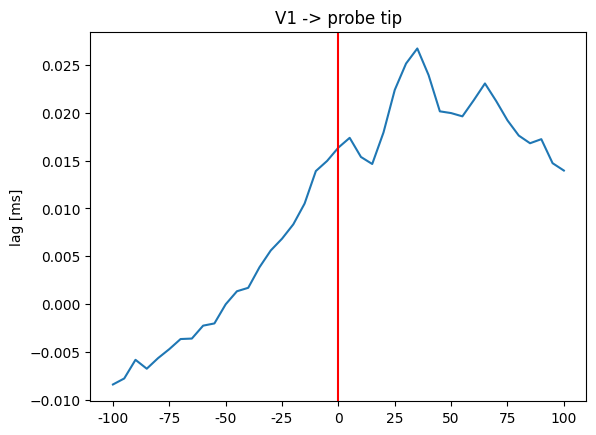

In [242]:
lp = get_lagplot_subset(dRSA, np.arange(20, 40))
fig, ax = plt.subplots()
print((np.argmax(lp) - 20)*5, "ms")
ax.plot(lp)
ax.axvline(20, color='red')
ax.set_xticks(np.arange(0, 41, 5))
ax.set_xticklabels(np.arange(-20, 21, 5)*cfg.avg_win)
ax.set_ylabel("similarity (corr)")
ax.set_ylabel("lag [ms]")
ax.set_title("V1 -> probe tip")